In [1]:

import os
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PD_DISPLAY_ROWS = 8
pd.set_option("display.max_rows", PD_DISPLAY_ROWS)
pd.set_option("display.max_columns", 50)

print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__)


Matplotlib is building the font cache; this may take a moment.


Versions -> numpy: 2.3.3 | pandas: 2.3.2



## Download the dataset

In [12]:

URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
CSV_PATH = "car_fuel_efficiency.csv"

# Preferred (as homework suggests):
try:
    if not os.path.exists(CSV_PATH):
        # Use wget if available
        exit_code = os.system(f"wget -q -O {CSV_PATH} {URL}")
        if exit_code != 0:
            raise RuntimeError("wget failed or is not installed.")
    print("Dataset is ready at:", os.path.abspath(CSV_PATH))
except Exception as e:
    print("wget path failed, trying pandas direct download...")
    # Fallback: read via pandas and save locally
    df_tmp = pd.read_csv(URL)
    df_tmp.to_csv(CSV_PATH, index=False)
    print("Downloaded via pandas and saved to:", os.path.abspath(CSV_PATH))


Dataset is ready at: /Users/pavloskorodziievskyi/Downloads/car_fuel_efficiency.csv



## Load data and keep only the required columns


In [14]:

use_cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = pd.read_csv(CSV_PATH, usecols=use_cols)

print("Shape:", df.shape)
df.head()


Shape: (9704, 5)


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369



## EDA — Target distribution

Does `fuel_efficiency_mpg` have a long tail? 
We plot a histogram and compute skewness. (Right/positive skew suggests a long tail to the right.)


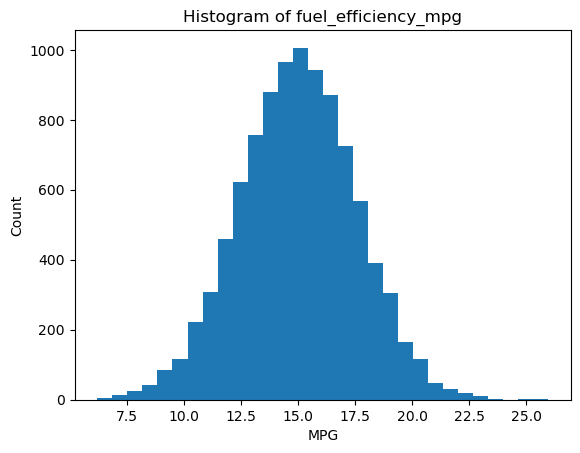

Skewness: -0.012
Interpretation: Positive skew -> long right tail; Negative -> long left tail.


In [15]:

target = 'fuel_efficiency_mpg'
fig = plt.figure()
plt.hist(df[target].dropna(), bins=30)
plt.title("Histogram of fuel_efficiency_mpg")
plt.xlabel("MPG")
plt.ylabel("Count")
plt.show()

skew_val = df[target].skew()
print("Skewness:", round(float(skew_val), 3))
print("Interpretation: Positive skew -> long right tail; Negative -> long left tail.")



## Q1. Which column has missing values?

We check only these columns and count missing values.


In [16]:

na_counts = df.isna().sum()
print(na_counts)

# Identify which of the specified columns has missing values (if any)
na_columns = na_counts[na_counts > 0].index.tolist()
print("\nColumns with missing values among the selected:", na_columns)


engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Columns with missing values among the selected: ['horsepower']



## Q2. Median of `horsepower`


In [6]:

hp_median = float(df['horsepower'].median())
print("horsepower median:", hp_median)

# Which option is closest?
options = np.array([49, 99, 149, 199], dtype=float)
closest_opt = options[np.argmin(np.abs(options - hp_median))]
print("Closest option:", closest_opt)


horsepower median: 149.0
Closest option: 149.0



## Prepare & split helpers


In [17]:

def shuffle_split(df, seed=42, train_frac=0.6, val_frac=0.2):
    n = len(df)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)

    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train+n_val]
    test_idx = idx[n_train+n_val:]

    return df.iloc[train_idx].copy(), df.iloc[val_idx].copy(), df.iloc[test_idx].copy()

def prepare_X(df, y_col='fuel_efficiency_mpg'):
    # Numerical features only; add bias column of ones
    features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
    X = df[features].values
    # add bias
    ones = np.ones(len(df))
    X = np.column_stack([ones, X])
    y = df[y_col].values
    return X, y

def train_linear_regression(X, y, r=0.0):
    # Normal equation with L2 (ridge): (X^T X + r*I)^(-1) X^T y
    # Do not regularize the bias term
    XTX = X.T.dot(X)
    XTy = X.T.dot(y)
    if r > 0:
        # create regularization matrix
        reg = r * np.eye(XTX.shape[0])
        reg[0, 0] = 0.0  # don't penalize bias
        XTX = XTX + reg
    w = np.linalg.solve(XTX, XTy)
    return w

def predict(X, w):
    return X.dot(w)

def rmse(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred) ** 2))



## Q3. Missing values: fill with 0 vs with train-mean (no regularization)

- Shuffle with seed 42
- Split 60/20/20
- Try filling missing values in the problematic column with **0** and with **mean (from train only)**
- Train simple linear regression (r=0) and evaluate on validation set  
- Report RMSE (rounded to 2 decimals) and which option is better


In [19]:

# Split
df_train, df_val, df_test = shuffle_split(df, seed=42, train_frac=0.6, val_frac=0.2)

# Detect the single problematic column from Q1 programmatically
na_counts_train = df_train.isna().sum()
problem_cols = na_counts_train[na_counts_train > 0].index.tolist()
problem_col = problem_cols[0] if len(problem_cols) > 0 else None
print("Problematic column:", problem_col)

results_q3 = {}

# Strategy 1: fill with 0
df_train_0 = df_train.copy()
df_val_0 = df_val.copy()
if problem_col:
    df_train_0[problem_col] = df_train_0[problem_col].fillna(0)
    df_val_0[problem_col] = df_val_0[problem_col].fillna(0)

Xtr, ytr = prepare_X(df_train_0)
Xv, yv = prepare_X(df_val_0)
w0 = train_linear_regression(Xtr, ytr, r=0.0)
rmse0 = rmse(yv, predict(Xv, w0))
results_q3["fill_0"] = round(rmse0, 2)

# Strategy 2: fill with train mean
df_train_m = df_train.copy()
df_val_m = df_val.copy()
if problem_col:
    mean_val = df_train_m[problem_col].mean()
    df_train_m[problem_col] = df_train_m[problem_col].fillna(mean_val)
    df_val_m[problem_col] = df_val_m[problem_col].fillna(mean_val)

Xtrm, ytrm = prepare_X(df_train_m)
Xvm, yvm = prepare_X(df_val_m)
wm = train_linear_regression(Xtrm, ytrm, r=0.0)
rmsem = rmse(yvm, predict(Xvm, wm))
results_q3["fill_mean"] = round(rmsem, 2)

print("RMSE with fill=0  :", results_q3["fill_0"])
print("RMSE with fill=mean:", results_q3["fill_mean"])

better = "Both are equally good"
if results_q3["fill_0"] < results_q3["fill_mean"]:
    better = "With 0"
elif results_q3["fill_mean"] < results_q3["fill_0"]:
    better = "With mean"
print("Better option:", better)


Problematic column: horsepower
RMSE with fill=0  : 0.52
RMSE with fill=mean: 0.47
Better option: With mean



## Q4. Ridge (L2) regularization

- Fill NAs with 0
- Try r in `[0, 0.01, 0.1, 1, 5, 10, 100]`
- Evaluate on validation set (seed=42 split from above)
- Report RMSE rounded to 2 decimals and select the best r (smallest r in case of ties)


In [20]:

# Reuse df_train/df_val from the seed=42 split

def fillna_zero(df_in):
    out = df_in.copy()
    return out.fillna(0)

df_train_z = fillna_zero(df_train)
df_val_z = fillna_zero(df_val)

Xtr, ytr = prepare_X(df_train_z)
Xv, yv = prepare_X(df_val_z)

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

rmse_by_r = {}
best_rmse = float("inf")
best_r = None

for r in r_list:
    w = train_linear_regression(Xtr, ytr, r=r)
    score = rmse(yv, predict(Xv, w))
    rmse_by_r[r] = round(score, 2)
    if round(score, 6) < round(best_rmse, 6) or (abs(score - best_rmse) < 1e-9 and (best_r is None or r < best_r)):
        best_rmse = score
        best_r = r

print("RMSE by r:")
for r in r_list:
    print(f"r={r:<6} -> RMSE: {rmse_by_r[r]}")

print("\nBest r:", best_r, "| Best RMSE (rounded):", round(best_rmse, 2))


RMSE by r:
r=0      -> RMSE: 0.52
r=0.01   -> RMSE: 0.52
r=0.1    -> RMSE: 0.52
r=1      -> RMSE: 0.52
r=5      -> RMSE: 0.52
r=10     -> RMSE: 0.52
r=100    -> RMSE: 0.52

Best r: 0 | Best RMSE (rounded): 0.52



## Q5. Effect of seed on RMSE stability

- Try seeds `0..9`
- Split 60/20/20 each time
- Fill NAs with 0
- Train **no regularization** model
- Collect validation RMSEs and compute `np.std` (round to 3 decimals)


In [21]:

seeds = list(range(10))
val_rmses = []

for s in seeds:
    tr, va, te = shuffle_split(df, seed=s, train_frac=0.6, val_frac=0.2)
    tr = tr.fillna(0)
    va = va.fillna(0)
    Xtr, ytr = prepare_X(tr)
    Xv, yv = prepare_X(va)
    w = train_linear_regression(Xtr, ytr, r=0.0)
    score = rmse(yv, predict(Xv, w))
    val_rmses.append(score)

val_rmses = np.array(val_rmses, dtype=float)
std_val = float(np.std(val_rmses))
print("Validation RMSEs:", [round(x, 3) for x in val_rmses])
print("STD:", round(std_val, 3))

# Choose closest option among [0.001, 0.006, 0.060, 0.600]
opts = np.array([0.001, 0.006, 0.060, 0.600])
closest = opts[np.argmin(np.abs(opts - round(std_val, 3)))]
print("Closest option:", closest)


Validation RMSEs: [np.float64(0.521), np.float64(0.524), np.float64(0.525), np.float64(0.524), np.float64(0.526), np.float64(0.525), np.float64(0.52), np.float64(0.51), np.float64(0.52), np.float64(0.532)]
STD: 0.005
Closest option: 0.006



## Q6. Final model

- Split with seed **9**
- Combine train and validation
- Fill NAs with 0
- Train with `r = 0.001`
- Report **test RMSE** (rounded) and the closest option


In [22]:

tr, va, te = shuffle_split(df, seed=9, train_frac=0.6, val_frac=0.2)
full_train = pd.concat([tr, va], axis=0).reset_index(drop=True)

full_train = full_train.fillna(0)
te = te.fillna(0)

Xfull, yfull = prepare_X(full_train)
Xte, yte = prepare_X(te)

w_final = train_linear_regression(Xfull, yfull, r=0.001)
test_rmse = rmse(yte, predict(Xte, w_final))
print("Test RMSE:", round(test_rmse, 3))

# Options: 0.15, 0.515, 5.15, 51.5
opts = np.array([0.15, 0.515, 5.15, 51.5])
closest = opts[np.argmin(np.abs(opts - round(test_rmse, 3)))]
print("Closest option:", closest)


Test RMSE: 0.505
Closest option: 0.515
